In [1]:
import pandas as pd
import numpy as np
import io
import os
import matplotlib.pyplot as plt

In [2]:
PLOT_DIR = "/home/biddisco/build/alloc-test/debug/plot/"

In [3]:
# rewrite above code as a function taking the filename as an argument
def read_malloc_output(filename, debug=False):
    # if file does not exist return empty dataframe
    if not os.path.isfile(filename):
        return None

    with open(filename, "r") as hw_file:
        hw_output_text = hw_file.read()

    hw_start_marker = "columns:"
    hw_start_index = hw_output_text.find(hw_start_marker) + len(hw_start_marker)
    hw_table_text = hw_output_text[hw_start_index:]

    # read csv into pandas dataframe, first row is column names
    hw_df = pd.read_csv(io.StringIO(hw_table_text), header=None, delimiter=",", skipinitialspace=True)
    if debug:
        display(hw_df)

    # set column names from first row
    hw_df.columns = list(hw_df.iloc[0, 0::1])
    # drop first row    
    hw_df = hw_df.iloc[1:, 0::1]

    # convert all columns to numeric values
    hw_df = hw_df.apply(pd.to_numeric)
    if debug:
        display(hw_df)
    return hw_df

<AxesSubplot:title={'center':'Memory use?'}, xlabel='Threads', ylabel='RSS Max/AllocatedMax'>

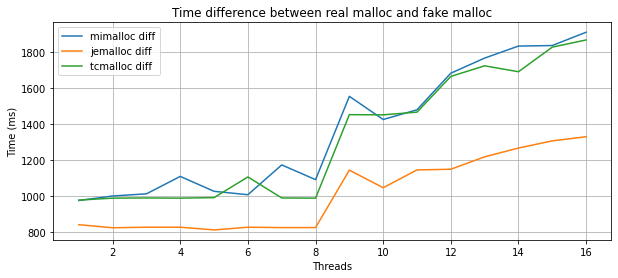

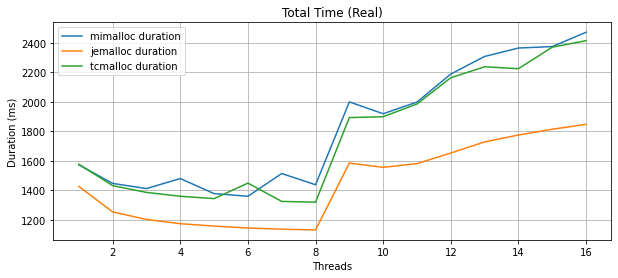

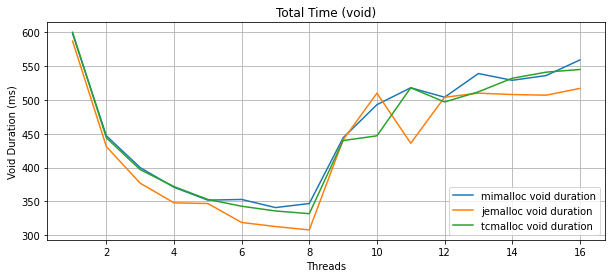

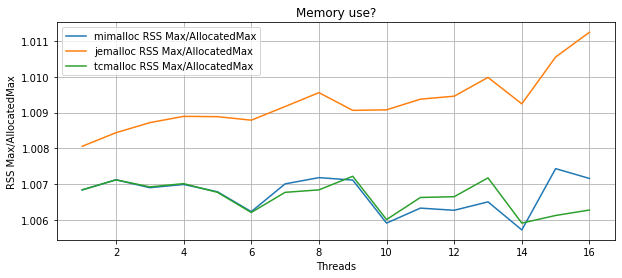

In [4]:
show_debug = False
results = {}
results["mimalloc"] = read_malloc_output(PLOT_DIR + "test_mimalloc.txt", debug=show_debug)
results["jemalloc"] = read_malloc_output(PLOT_DIR + "test_jemalloc.txt")
results["tcmalloc"] = read_malloc_output(PLOT_DIR + "test_tcmalloc.txt")

# create empty dataframe 
diff = pd.DataFrame()
diff_list = []
duration_list = []
dur_void_list = []
rss_list = []

for name, df in results.items():
    if df is not None:
        # combine columns we want from each dataframe into a single final dataframe, append _x to duplicated column names
        diff = pd.merge(diff, df[["thread", "diff(ms)", "duration(ms)", "duration of void(ms)", "(RSS max<<12)/allocatedMax"]], left_index=True, right_index=True, how='outer', suffixes=('', '_y'))
        # rename each column we want to include the name of the allocator
        diff.rename(columns={"diff(ms)": name +" diff"}, inplace=True)
        diff.rename(columns={"duration(ms)": name +" duration"}, inplace=True)
        diff.rename(columns={"duration of void(ms)": name +" void duration"}, inplace=True)
        diff.rename(columns={"(RSS max<<12)/allocatedMax": name +" RSS Max/AllocatedMax"}, inplace=True)

        # add valid diff column name to final plot list
        diff_list.append(name +" diff")
        duration_list.append(name +" duration")
        dur_void_list.append(name +" void duration")
        rss_list.append(name +" RSS Max/AllocatedMax")

# delete columns that are jjust duplicate like 'thread'
diff.drop(diff.filter(regex='_y$').columns, axis=1, inplace=True)

if show_debug:
    display(diff)

diff.plot(x='thread', y=diff_list,     figsize=(10,4), grid=True, xlabel="Threads", ylabel="Time (ms)", title="Time difference between real malloc and fake malloc")
diff.plot(x='thread', y=duration_list, figsize=(10,4), grid=True, xlabel="Threads", ylabel="Duration (ms)", title="Total Time (Real)")
diff.plot(x='thread', y=dur_void_list, figsize=(10,4), grid=True, xlabel="Threads", ylabel="Void Duration (ms)", title="Total Time (void)")
diff.plot(x='thread', y=rss_list,      figsize=(10,4), grid=True, xlabel="Threads", ylabel="RSS Max/AllocatedMax", title="Memory use?")
